# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

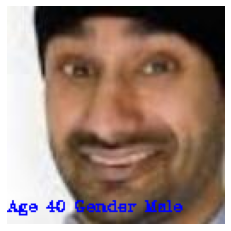

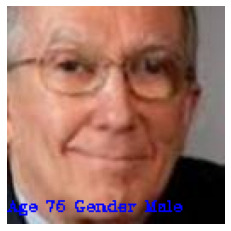

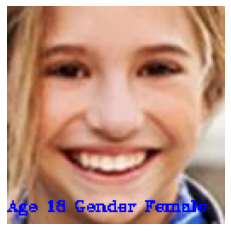

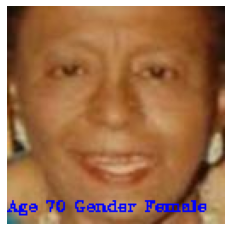

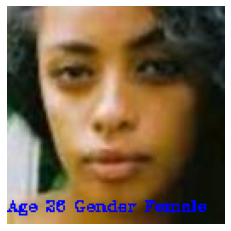

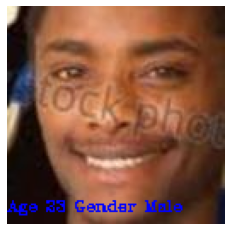

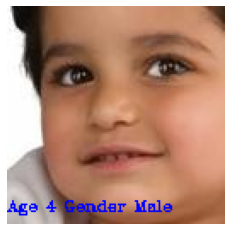

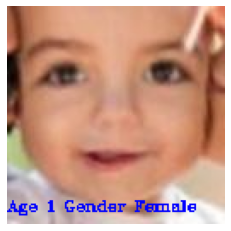

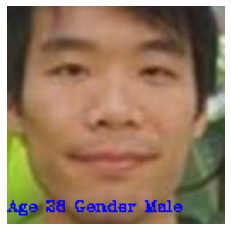

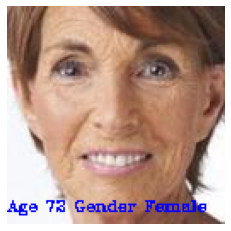

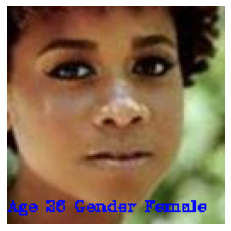

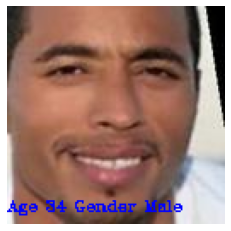

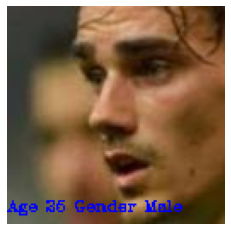

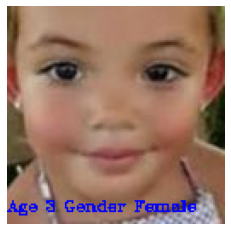

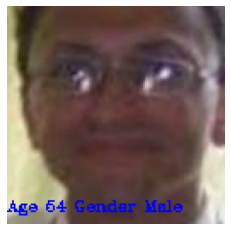

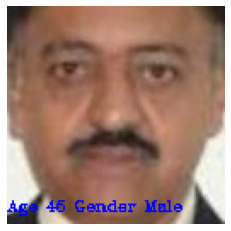

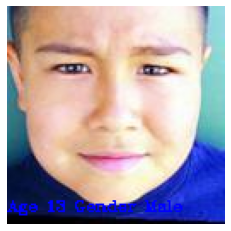

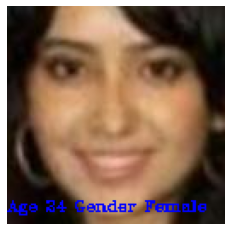

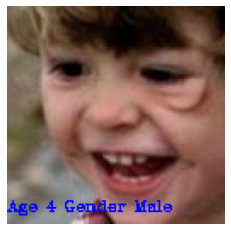

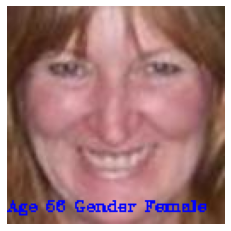

In [3]:
import matplotlib.pyplot as plt
import cv2 as cv
import os

img_path = "drive/MyDrive/train_val/"

# display 20 images from the train_val folder
for i in range(20):
    path = os.listdir(img_path)[i]
    labels = path.split("_")
    age = labels[0]
    gender = labels[1]
    img = cv.imread(img_path + path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.putText(img, text='Age {} Gender {}'.format(age, "Male" if gender == '0' else "Female"),
                     org=(0, 120),
                     color=(0, 0, 255),
                     fontFace=cv.FONT_HERSHEY_COMPLEX,
                     fontScale=0.3)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [4]:
path = os.listdir(img_path)[0]
img = cv.imread(img_path + path)
print(img.shape)

(128, 128, 3)


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [5]:
dataset = []
label = []

# divide the image label  to age and gender for train test split
for name in os.listdir(img_path):
    labels = name.split("_")
    age = labels[0]
    gender = labels[1]
    img = cv.imread(img_path + name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    dataset.append(img)
    label.append([age, gender])


In [6]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# X is the dataset of the image
X = np.array(dataset, dtype="uint8")
# Y is the dataset of the age and gender
Y = np.array(label, dtype="uint8")
# split the data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=0)

In [7]:
np.shape(X_train)

(4000, 128, 128, 3)

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# data augmentation
data_gen = ImageDataGenerator(brightness_range=[0.3, 0.5],
                              zoom_range = 0.2,
                              rescale=1.0 / 255,
                              )


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

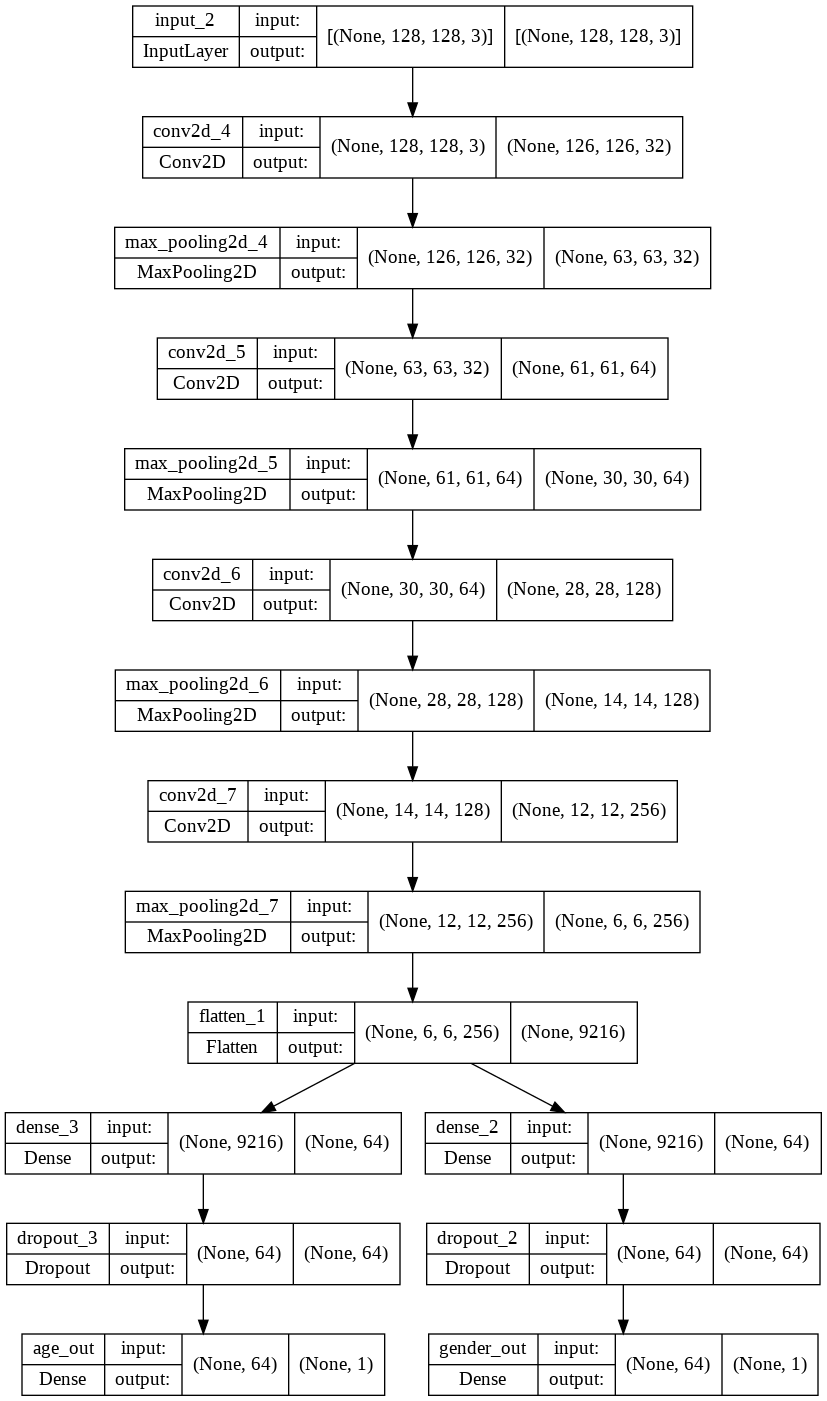

In [13]:
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Input, MaxPooling2D, Flatten

# input size of the model
inputs = Input((128, 128, 3))
# 2D convolutionary layers with 32 neurons indicating the dimensions of output space with height and width of 3 by 3
conv_1 = Conv2D(32, kernel_size=(3, 3))(inputs)
# DownSamples the previous layer to maximum size of 2 by 2
maxpool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
# 2D convolutionary layers with 64 neurons indicating the dimensions of output space with height and width of 3 by 3
conv_2 = Conv2D(64, kernel_size=(3, 3))(maxpool_1)
# DownSamples the previous layer to maximum size of 2 by 2
maxpool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
# 2D convolutionary layers with 128 neurons indicating the dimensions of output space with height and width of 3 by 3
conv_3 = Conv2D(128, kernel_size=(3, 3))(maxpool_2)
# DownSamples the previous layer to maximum size of 2 by 2
maxpool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
# 2D convolutionary layers with 256 neurons indicating the dimensions of output space with height and width of 3 by 3
conv_4 = Conv2D(256, kernel_size=(3, 3))(maxpool_3)
# DownSamples the previous layer to maximum size of 2 by 2
maxpool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
# flatten the output layer to 1-dimension
flatten = Flatten()(maxpool_4)
# Add a fully connected layer with 64 hidden units and ReLU activation
dense_1 = Dense(64, activation='relu')(flatten)
dense_2 = Dense(64, activation='relu')(flatten)
# Add a dropout rate of 0.2
drop_1 = Dropout(0.2)(dense_1)
drop_2 = Dropout(0.2)(dense_2)
# Add a final sigmoid/relu layer with 1 node for classification output
output_1 = Dense(1, activation="sigmoid", name='gender_out')(drop_1)
output_2 = Dense(1, activation="relu", name='age_out')(drop_2)

modelA = Model(inputs=[inputs], outputs=[output_2, output_1])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [14]:
def generator(gen, x, y):
    g = gen.flow(x, y, batch_size=32)
    while True:
        x1, y1 = g.next()
        yield x1, np.split(y1, indices_or_sections=2, axis=1)

In [15]:
model_path = "C:/ML2/"

# Change steps per epoch based on data

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping( monitor='val_loss', 
min_delta = 0.001,
patience=5,
restore_best_weights=True)

modelA.compile(loss=["mae", "binary_crossentropy"],
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
               metrics={'age_out': 'mean_absolute_error', 'gender_out': "accuracy"})

history = modelA.fit_generator(generator(data_gen, X_train, y_train.reshape(4000, 2)),
                     steps_per_epoch=128,
                     callbacks=[early_stop],
                     epochs=40,
                     validation_data=generator(data_gen, X_val, y_val.reshape(1000, 2)),
                     validation_steps=32)

modelA.save(model_path + "age_gender_A.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/40
128/128 [==============================] - 27s 205ms/step - loss: 18.2534 - age_out_loss: 17.5442 - gender_out_loss: 0.7092 - age_out_mean_absolute_error: 17.5442 - gender_out_accuracy: 0.5469 - val_loss: 15.8239 - val_age_out_loss: 15.1331 - val_gender_out_loss: 0.6909 - val_age_out_mean_absolute_error: 15.1331 - val_gender_out_accuracy: 0.4920
Epoch 2/40
128/128 [==============================] - 27s 212ms/step - loss: 15.5078 - age_out_loss: 14.8291 - gender_out_loss: 0.6787 - age_out_mean_absolute_error: 14.8291 - gender_out_accuracy: 0.5420 - val_loss: 14.6320 - val_age_out_loss: 13.9936 - val_gender_out_loss: 0.6384 - val_age_out_mean_absolute_error: 13.9936 - val_gender_out_accuracy: 0.6180
Epoch 3/40
128/128 [==============================] - 25s 198ms/step - loss: 13.9106 - age_out_loss: 13.2970 - gender_out_loss: 0.6137 - age_out_mean_absolute_error: 13.2970 - gender_out_accuracy: 0.6699 - val_loss: 12.4630 - val_age_out_loss: 11.9102 - val_gender_out_loss: 0.5528 

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


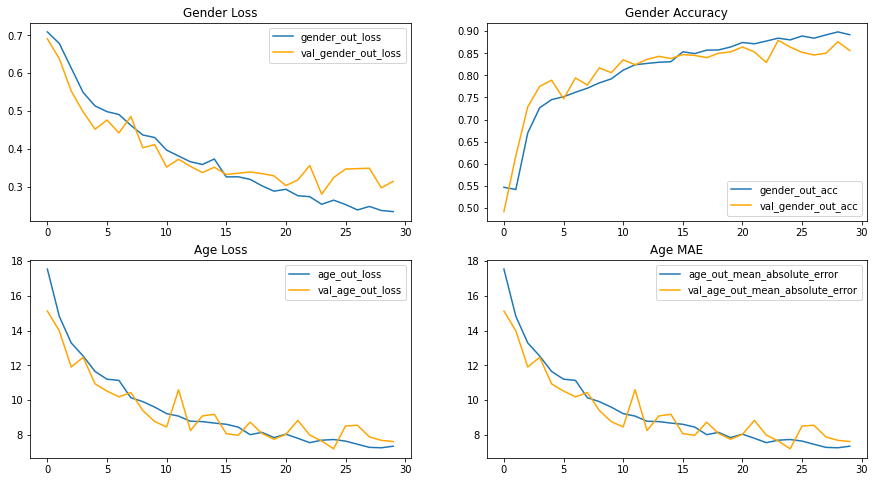

In [16]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['gender_out_loss'], label='gender_out_loss')
plt.plot(history.history['val_gender_out_loss'], color='orange', label='val_gender_out_loss')
plt.title("Gender Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['gender_out_accuracy'], label='gender_out_acc')
plt.plot(history.history['val_gender_out_accuracy'], color='orange', label='val_gender_out_acc')
plt.title("Gender Accuracy")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['age_out_loss'], label='age_out_loss')
plt.plot(history.history['val_age_out_loss'], color='orange', label='val_age_out_loss')
plt.title("Age Loss")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['age_out_mean_absolute_error'], label='age_out_mean_absolute_error')
plt.plot(history.history['val_age_out_mean_absolute_error'], color='orange', label='val_age_out_mean_absolute_error')
plt.title("Age MAE")
plt.legend()

plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


83697664/83683744 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 4, 4, 2048)   20861480    ['input_4[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 32768)        0           ['xception[0][0]']               
                                                                                                  
 dense_5 (Dense)           

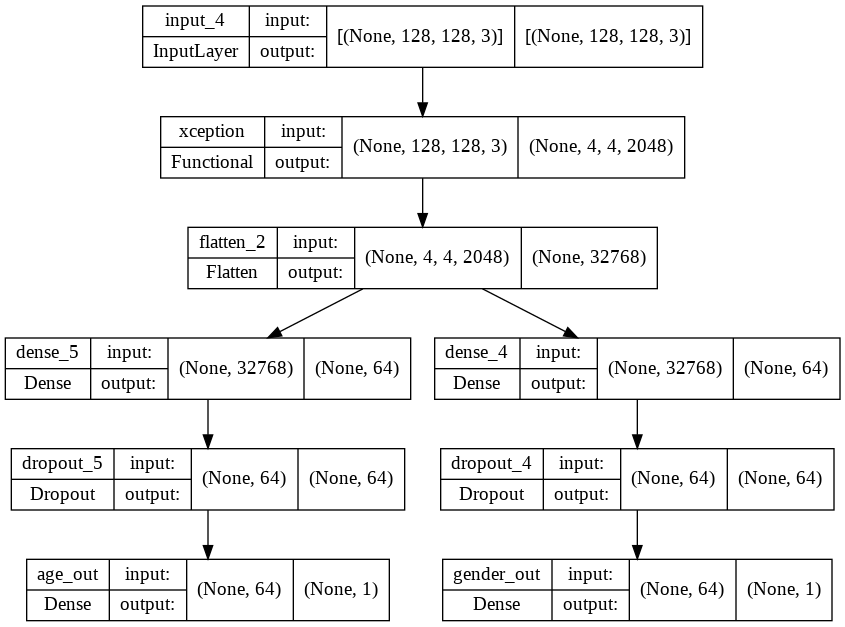

In [17]:
from keras.applications.xception import Xception

# getting pre_trained layer from Xception while leaving out the last fully_connected layer
pre_trained = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# make the layer non_trainable since we dont have to train all of them
pre_trained.trainable = False

# the input size of image
inputs = Input(shape=(128, 128, 3))
x = pre_trained(inputs, training=False)

# flatten the output layer to 1-dimension
flatten = Flatten()(x)

# Add a fully connected layer with 64 hidden units and ReLU activation
dense_1 = Dense(64, activation='relu')(flatten)
dense_2 = Dense(64, activation='relu')(flatten)

# Add a dropout rate of 0.2
drop_1 = Dropout(0.2)(dense_1)
drop_2 = Dropout(0.2)(dense_2)

# Add a final sigmoid/relu layer with 1 node for classification output
output_1 = Dense(1, activation="sigmoid", name='gender_out')(drop_1)
output_2 = Dense(1, activation="relu", name='age_out')(drop_2)

modelB = Model(inputs=[inputs], outputs=[output_2, output_1])
modelB.summary()

from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [18]:
modelB.compile(loss=["mae", "binary_crossentropy"],
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #"Adam",
               metrics={'age_out': 'mean_absolute_error', 'gender_out': "accuracy"})

historyB1 = modelB.fit_generator(generator(data_gen, X_train, y_train.reshape(4000, 2)),
                     steps_per_epoch=128,
                     callbacks=[early_stop],
                     epochs=20,
                     validation_data=generator(data_gen, X_val, y_val.reshape(1000, 2)),
                     validation_steps=32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
128/128 [==============================] - 38s 245ms/step - loss: 12.5981 - age_out_loss: 12.0693 - gender_out_loss: 0.5288 - age_out_mean_absolute_error: 12.0693 - gender_out_accuracy: 0.7576 - val_loss: 10.6481 - val_age_out_loss: 10.2089 - val_gender_out_loss: 0.4393 - val_age_out_mean_absolute_error: 10.2089 - val_gender_out_accuracy: 0.7790
Epoch 2/20
128/128 [==============================] - 29s 228ms/step - loss: 10.9018 - age_out_loss: 10.4745 - gender_out_loss: 0.4273 - age_out_mean_absolute_error: 10.4745 - gender_out_accuracy: 0.7983 - val_loss: 10.2977 - val_age_out_loss: 9.9017 - val_gender_out_loss: 0.3959 - val_age_out_mean_absolute_error: 9.9017 - val_gender_out_accuracy: 0.8200
Epoch 3/20
128/128 [==============================] - 29s 229ms/step - loss: 10.2791 - age_out_loss: 9.8830 - gender_out_loss: 0.3960 - age_out_mean_absolute_error: 9.8830 - gender_out_accuracy: 0.8123 - val_loss: 9.9956 - val_age_out_loss: 9.5848 - val_gender_out_loss: 0.4108 - val_

In [20]:
from tensorflow.keras.optimizers import Adam

pre_trained.trainable = True
modelB.compile(loss=["mae", "binary_crossentropy"],
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
               metrics={'age_out': 'mean_absolute_error', 'gender_out': "accuracy"})

historyB2 = modelB.fit_generator(generator(data_gen, X_train, y_train.reshape(4000, 2)),
                     steps_per_epoch=128,
                     callbacks=[early_stop],
                     epochs=20,
                     validation_data=generator(data_gen, X_val, y_val.reshape(1000, 2)),
                     validation_steps=32)

modelB.save(model_path + "age_gender_B.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
128/128 [==============================] - 115s 509ms/step - loss: 8.7346 - age_out_loss: 8.4221 - gender_out_loss: 0.3125 - age_out_mean_absolute_error: 8.4221 - gender_out_accuracy: 0.8579 - val_loss: 9.5873 - val_age_out_loss: 9.2140 - val_gender_out_loss: 0.3733 - val_age_out_mean_absolute_error: 9.2140 - val_gender_out_accuracy: 0.8330
Epoch 2/20
128/128 [==============================] - 63s 494ms/step - loss: 8.5994 - age_out_loss: 8.3123 - gender_out_loss: 0.2870 - age_out_mean_absolute_error: 8.3123 - gender_out_accuracy: 0.8630 - val_loss: 9.2408 - val_age_out_loss: 8.8652 - val_gender_out_loss: 0.3756 - val_age_out_mean_absolute_error: 8.8652 - val_gender_out_accuracy: 0.8380
Epoch 3/20
128/128 [==============================] - 61s 479ms/step - loss: 8.5132 - age_out_loss: 8.2262 - gender_out_loss: 0.2870 - age_out_mean_absolute_error: 8.2262 - gender_out_accuracy: 0.8682 - val_loss: 9.0420 - val_age_out_loss: 8.6640 - val_gender_out_loss: 0.3781 - val_age_out_me

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

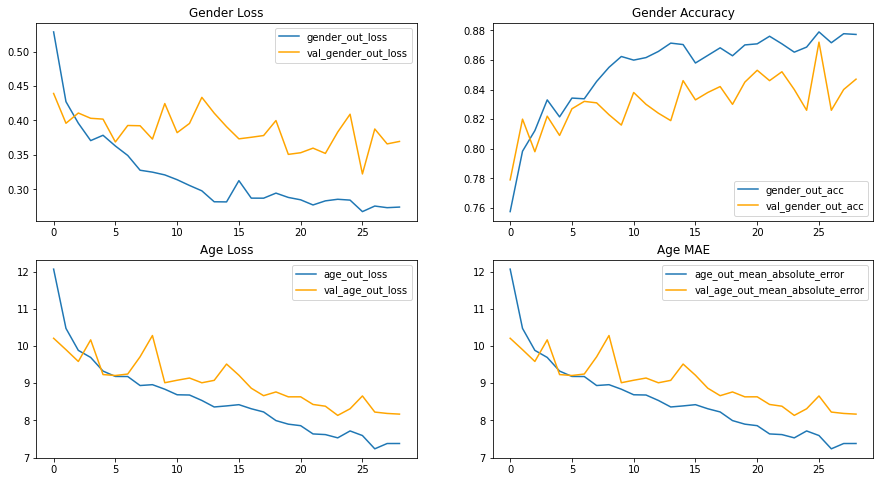

In [21]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(historyB1.history['gender_out_loss'] + historyB2.history['gender_out_loss'], label='gender_out_loss')
plt.plot(historyB1.history['val_gender_out_loss'] + historyB2.history['val_gender_out_loss'], color='orange', label='val_gender_out_loss')
plt.title("Gender Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(historyB1.history['gender_out_accuracy'] + historyB2.history['gender_out_accuracy'], label='gender_out_acc')
plt.plot(historyB1.history['val_gender_out_accuracy'] + historyB2.history['val_gender_out_accuracy'], color='orange', label='val_gender_out_acc')
plt.title("Gender Accuracy")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(historyB1.history['age_out_loss'] + historyB2.history['age_out_loss'], label='age_out_loss')
plt.plot(historyB1.history['val_age_out_loss'] + historyB2.history['val_age_out_loss'], color='orange', label='val_age_out_loss')
plt.title("Age Loss")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(historyB1.history['age_out_mean_absolute_error'] + historyB2.history['age_out_mean_absolute_error'], label='age_out_mean_absolute_error')
plt.plot(historyB1.history['val_age_out_mean_absolute_error'] + historyB2.history['val_age_out_mean_absolute_error'], color='orange', label='val_age_out_mean_absolute_error')
plt.title("Age MAE")
plt.legend()

plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#